# Introduction to NetworkModelGrid
This tutorial provides a basic introduction to the ``NetworkModelGrid`` grid class in Landlab. 

In its current form it is intended to highlight current capabilities and spark discussion on what sort of capabilities this model grid class should have. 

In [1]:
# Start by importing necessary modules
from landlab.grid.network import NetworkModelGrid
import numpy as np

In [2]:
# define a grid, right now this is done by passing three datastructures:
# grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

y_of_node = (0, 1, 2, 2, 3)
x_of_node = (0, 0, -1, 1, 2)
nodes_at_link = ((1, 0), (2, 1), (3, 1), (3, 4))
grid = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)


print(grid.x_of_node)
#array([ 0.,  0., -1.,  1.])
print(grid.y_of_node)
#array([ 0.,  1.,  2.,  2.])
print(grid.nodes_at_link)
#array([[0, 1],
#       [2, 1],
#       [1, 3]])

# we can store simple arrays at links and at nodes (complex things lower in the notebook)
grid.at_node['z'] = [1, 2, 3, 4, 5]
grid.at_link['z'] = [10, 20, 30, 40]

[ 0.  0. -1.  1.  2.]
[ 0.  1.  2.  2.  3.]
[[0 1]
 [2 1]
 [1 3]
 [3 4]]


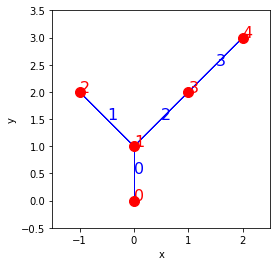

In [3]:
# there is a nice plotting function for simple graphs. 

from landlab.plot import graph
graph.plot_graph(grid, at='node,link')

In [4]:
# We can get information about the grid

# see http://landlab.readthedocs.io/en/release/landlab.grid.base.html#getting-information-about-a-grid
# for information about what we can get
# We can only get things that require only nodes and links
# For the standard divergences in landlab, a face or cell is also required, so we don't have those. 

# for example link directions at node, these are defined by the orientation
# in cartesian space, not based on flow direction.

# 1=incoming flux, -1=outgoing flux, 0=no flux.
grid.link_dirs_at_node


array([[-1,  0,  0],
       [-1,  1,  1],
       [-1,  0,  0],
       [-1,  1,  0],
       [ 1,  0,  0]])

In [5]:
# we gan get things like the node at link head
grid.node_at_link_head

array([1, 1, 3, 4])

In [21]:
grid.node_at_link_tail

array([0, 2, 1, 3])

In [6]:
# We can use these datastructures to move around 
# on the grid. 

# for example, here we'll get the value for z on the
# node that is at the link head. 
for ind in grid.node_at_link_head:
    print(grid.at_node['z'][ind])


2
2
4
5


In [7]:
# and the nodes next to each node
# here and most other places in Landlab
# -1 is a fill value that means
# there is no neighbor
grid.adjacent_nodes_at_node

array([[ 1, -1, -1],
       [ 3,  2,  0],
       [ 1, -1, -1],
       [ 4,  1, -1],
       [ 3, -1, -1]])

In [8]:
# lets add topography and make it go with Y, so we have a sloping network. 

# landlab's components make some assumptions about what different fields are 
# named. Typically the elevation of the surface of the earth is called
# topographic__elevation

z_node = grid.add_ones('topographic__elevation', at='node')
z_node += grid.y_of_node

# we are going to route flow over the network, and this requires
# that each node has some area. 

# for NetworkModelGrids this means that there must be an
# at-node array called cell_area_at_node.
# For now we'll make it have ones, but if you had specific drainage
# areas associated with each node, then you could put this here. 
area = grid.add_ones('cell_area_at_node', at = 'node')


In [9]:
# We'll import the flow accumulator and run it. 

from landlab.components import FlowAccumulator
fa = FlowAccumulator(grid)
fa.run_one_step()


In [10]:
# The flow accumulator has made a bunch of additional fields for our model grid. 

grid.at_node.keys()

Frozen(OrderedDict([('node', <xarray.IndexVariable 'node' (node: 5)>
array([0, 1, 2, 3, 4])), ('mesh', <xarray.Variable ()>
array('a',
      dtype='<U1')
Attributes:
    cf_role:                 mesh_topology
    long_name:               Topology data of 2D unstructured mesh
    topology_dimension:      2
    node_coordinates:        x_of_node y_of_node
    face_node_connectivity:  nodes_at_patch
    face_dimension:          patch
    face_edge_connectivity:  links_at_patch
    edge_node_connectivity:  nodes_at_link
    edge_dimension:          link), ('y_of_node', <xarray.Variable (node: 5)>
array([ 0.,  1.,  2.,  2.,  3.])
Attributes:
    long_name:  y
    units:      m), ('x_of_node', <xarray.Variable (node: 5)>
array([ 0.,  0., -1.,  1.,  2.])
Attributes:
    long_name:  x
    units:      m), ('nodes_at_link', <xarray.Variable (link: 4, Two: 2)>
array([[0, 1],
       [2, 1],
       [1, 3],
       [3, 4]])
Attributes:
    cf_role:      edge_node_connectivity
    long_name:    nodes 

In [11]:
# for example the flow reciever node is the node ID of each node's flow reciever. 
grid['node']['flow__receiver_node']

array([0, 0, 1, 1, 3])

In [12]:
# in our call, we discussed a few things people would like to be able to easily access
# Here is a quick attempt at doing these:

# Identify which nodes have no incoming links. 
# The landlab standard is that a node that flows to itself has a 
# flow__receiver_node value of its node ID. this makes it easy to find
# outlets

outlet_ids = np.where(grid['node']['flow__receiver_node'] == grid.nodes)[0]
print(outlet_ids)

# Ability to assign direction to links (not link_dirs, but like a directed graph)
# the FlowAccumulator component assigns a reciever node based on topography. 

# one way to do this is to use the flow recievers. 
# if necessary, we could also make a version of the link_dirs_at_node
# attribute that was link_flow_dirs_at_node
recievers = grid['node']['flow__receiver_node']

# Get the flow data structure (this has built into it starting 
# from nodes that have no drainage area and working to the outlet).
downstream_to_upstream_structure = grid['node']['flow__upstream_node_order']

# itterate from upstream to downstream 
for node in downstream_to_upstream_structure[-1:0:-1]:
    reciever = recievers[node]
    print('Node ', node, ' flows to ', reciever)

# if one wated to find out which nodes have no incoming flow, we'd either
# need to add this to what the flowAccumulator saves (it calculates this, but
# doesn't save it). 

# or we could just re-calculate it. 

from landlab.components.flow_accum import flow_accum_bw
number_of_donors = flow_accum_bw._make_number_of_donors_array(recievers)

headwater_nodes = np.where(number_of_donors==0)[0]
print(headwater_nodes)


[0]
Node  4  flows to  3
Node  3  flows to  1
Node  2  flows to  1
Node  1  flows to  0
[2 4]


In [13]:
# methods that work for with only links and nodes on other landlab grids
# work here too. 
grid.calc_grad_at_link(z_node)


array([ 1.        , -0.70710678,  0.70710678,  0.70710678])

In [14]:
# and we can save to the Ugrid format
#grid.to_netcdf('network.nc')

In [15]:
# we think this should work, but its not working on Katy's computer
#!ncdump -h network.nc

In [16]:
# Though a netcdf is created
!ls

Example_Usage_of_Network_Model_Grid.ipynb
network.nc


One might want to store more complicated things at grids and nodes. Two things that have come up in discussions are:

1) Storing ragged arrays at links and nodes

2) Storing profiles (e.g. long channel profiles) on links. 

The next two cells give an example of such datastructures. 

These two examples work, though we don't know the efficiency in model usage of these implementations. 

These work because we can create a numpy object array of length number-of-links or number-of-nodes and store this array at links or nodes. 

Here we've stored numpy arrays and dictionaries, but it could be lists, sets, etc. 

In [17]:
# its important to john that he can also store the time dimention
# John has attributes for links, nodes, and parcels. 
# Its important for him to be able to calculate math values, aggregate/min/max statistics of the parcels on the graph elements
# 

#sediment_data = ...

#aggregated_data = sediment_data.sum(grid, at='links', attribute='volume')


# this would produce a number of links long array of the sum of volume of parcels at link. 


# store ragged arrays at links and nodes
sediment_id = [[0],
               [3,5],
               [2,1,4,6], 
               [59, 30]]

grid.at_link['sediment_id']=sediment_id


water_id = [np.array([0]),
            np.array([3,5]),
            np.array([2,1,4,6]),
            np.array([8,9,10,11]),
            np.array([18])]

grid.at_node['water_id']=water_id


In [18]:
from landlab import BAD_INDEX_VALUE
# we can move items around in these ragged arrays.
print(sediment_id)

# lets start from the outlet, and move the last arrived sediment ID downstream

# we'll need the flow link to recieving node
# the flow accumulator made this for us. 
flow__link_to_receiver_node = grid['node']['flow__link_to_receiver_node']

for node in downstream_to_upstream_structure:
    # get the reciever node
    reciever = recievers[node]
    
    # get the link flowing from source to reciever
    source_link = flow__link_to_receiver_node[node]
    
    # get the link flowing from the reciever node
    destination_link = flow__link_to_receiver_node[reciever]
     
    if source_link != BAD_INDEX_VALUE:
        try:

            moved = grid.at_link['sediment_id'][source_link].pop()
            print('Picking up sediment ', moved, 'from link ', source_link)

            if destination_link == BAD_INDEX_VALUE:
                # transporting below outlet, make the sediment disapear:
                print('Moving ', moved, ' out of the domain')
                pass
            else:
                print('Moving ', moved, ' from link ', source_link, ' to link ', destination_link)
                grid.at_link['sediment_id'][destination_link].append(moved)
        except IndexError:
            print('No sediment on link ', source_link)
print(sediment_id)
print(grid.at_link['sediment_id'])

[[0], [3, 5], [2, 1, 4, 6], [59, 30]]
Picking up sediment  0 from link  0
Moving  0  out of the domain
Picking up sediment  5 from link  1
Moving  5  from link  1  to link  0
Picking up sediment  6 from link  2
Moving  6  from link  2  to link  0
Picking up sediment  30 from link  3
Moving  30  from link  3  to link  2
[[5, 6], [3], [2, 1, 4, 30], [59]]
[list([5, 6]) list([3]) list([2, 1, 4, 30]) list([59])]


In [19]:
# store profiles at links and nodes
profiles_at_link = [{'x': np.arange(10), 'y': np.random.randn(10)},
                    {'x': np.arange(30), 'y': np.random.randn(30)},
                    {'x': np.arange(40), 'y': np.random.randn(40)},
                    {'x': np.arange(35), 'y': np.random.randn(25)}]

grid.at_link['sediment_id']=profiles_at_link

In [20]:
print(grid.at_link['sediment_id'])


[ {'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), 'y': array([ 0.1732675 ,  0.807132  , -1.01537786, -0.70644993, -0.3721693 ,
        0.46796334,  0.20653958,  0.28504137,  0.38994018,  0.30265848])}
 {'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]), 'y': array([ 1.12856282, -0.62021952,  0.4031351 ,  0.85231139,  0.32638089,
       -0.66946146, -1.04961697,  0.44977398,  0.05094622, -0.58483541,
        1.77672066,  0.40603511,  0.03781052, -0.18956223,  0.82998193,
        0.5776776 ,  0.91897503,  0.27364172,  1.45086455,  1.18214842,
       -0.36430515, -1.05891449,  1.05932302, -1.96363267,  1.01856725,
       -1.66679035, -1.19020571, -0.1042819 ,  0.45797583, -1.20543799])}
 {'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]), 'y': array([-0.38489567, -1.13

# Discussion
What other things need to be stored on the Grid?
